In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.display import display

from sklearn import metrics
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
from pdpbox import pdp
#from plotnine import *

In [4]:
df_raw = pd.read_csv('data/PUBG/train_V2.csv', low_memory=False)

In [5]:
toRel = ['assists', 'boosts', 'heals','revives', 'rideDistance', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired']

In [6]:
def timeAdapt(df, toRel, rel):
    for i in toRel:
        df[i] = df[i] / df[rel]
    return df

In [7]:
def funcTrans(x):
    return ((np.log(x/(1-x)))*0.2)+0.5

In [8]:
df_raw['wPPTrans'] = funcTrans(df_raw['winPlacePerc'].loc[df_raw['winPlacePerc'] !=1 & (df_raw['winPlacePerc'] != 0)])

In [9]:
df_raw['wPPTrans'].loc[df_raw['wPPTrans'].isna()] = df_raw['winPlacePerc']

In [10]:
df_raw['timeInMatch'] = (df_raw['wPPTrans'] * df_raw['matchDuration'])+1

In [11]:
df_raw = timeAdapt(df_raw, toRel, 'timeInMatch')

In [12]:
df_raw.drop(['Id', 'groupId', 'matchId', 'killStreaks', 'killPlace', 'headshotKills', 'roadKills', 'damageDealt', 'DBNOs', 'wPPTrans', 'timeInMatch', 'matchDuration', 'winPlacePerc'], axis=1, inplace=True)

In [13]:
train_cats(df_raw)

In [14]:
df_raw.dropna(subset=['kills'], inplace=True)

In [15]:
def splitMatchTypes(df, c):
    frameList = []
    for i in getattr(df_raw, c).unique().tolist():
        frameList.append(df[df[c] == i])
        
        
    return frameList

In [16]:
squadfpp, duo, solofpp, squad, duofpp, solo, normalsquadfpp, crashfpp, flaretpp, normalsolofpp, flarefpp, normalduofpp, normalduo, normalsquad, crashtpp, normalsolo = splitMatchTypes(df_raw, 'matchType')

In [17]:
fpp = pd.concat([squadfpp,duofpp,solofpp])

In [18]:
fpp_trn, fppy_trn, nas = proc_df(fpp, 'kills')

In [19]:
fpp_train, fpp_valid, fppy_train, fppy_valid = train_test_split(fpp_trn, fppy_trn, test_size = 0.2, random_state=1337)

In [20]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    res = ['trnError: ' + str(mean_absolute_error(m.predict(X_train), y_train)), 'valError: ' + str(mean_absolute_error(m.predict(X_valid), y_valid)),
                'trnR2: ' + str(m.score(X_train, y_train)), 'valR2: ' + str(m.score(X_valid, y_valid))]
    if hasattr(m, 'oob_score_'): res.append('oob: ' + str(m.oob_score_))
    print(res)

In [23]:
def split_vals(a,n): return a[:n], a[n:]

In [24]:
def get_opt_trees(x_train, y_train, ntrees, minleaves, maxfeatures):
    m = RandomForestRegressor(n_estimators=ntrees, min_samples_leaf=minleaves, max_features=maxfeatures, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    return m.oob_score_, m

In [25]:
def get_opt_par(x,y, trees = [100, 150, 200], leaves = [1, 3, 5, 15], features = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    parList = []
    for c in (trees):
        for d in (leaves):
            for e in (features):
                parList.append([get_opt_trees(x,y, c, d, e), c, d, e])
    parList.sort(key=lambda x: x[0], reverse=True)
    return parList[0]

In [26]:
#in case you are looking to fit the trees a little better, just player around with the get_opt_par() parameters
get_opt_par(fpp_train, fppy_train, [10,25,50], leaves = [1,5,15], features = [0.1,0.5,1])

KeyboardInterrupt: 

In [27]:
m_fpp = RandomForestRegressor(n_estimators=50, min_samples_leaf= 5, max_features=0.5, n_jobs=-1)
%time m_fpp.fit(fpp_train, fppy_train)

Wall time: 2min 38s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
print_score(m_fpp, fpp_train, fppy_train, fpp_valid, fppy_valid)

['trnError: 0.263679058682', 'valError: 0.386068788797', 'trnR2: 0.843761657727', 'valR2: 0.679730265869']


In [29]:
fi_fpp = rf_feat_importance(m_fpp, fpp_trn); fi_fpp[:10]

,cols,imp
4,longestKill,0.618491
1,boosts,0.126960
2,heals,0.058006
14,walkDistance,0.029485
15,weaponsAcquired,0.026728
3,killPoints,0.025414
9,revives,0.020944
8,rankPoints,0.020762
0,assists,0.020102
10,rideDistance,0.012838


In [30]:
x = get_sample(fpp_train, 500)

In [31]:
def plot_pdp(feat,  m, x, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<matplotlib.figure.Figure at 0x24d5213d1d0>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x24c8180dc50>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x24c8183a828>})

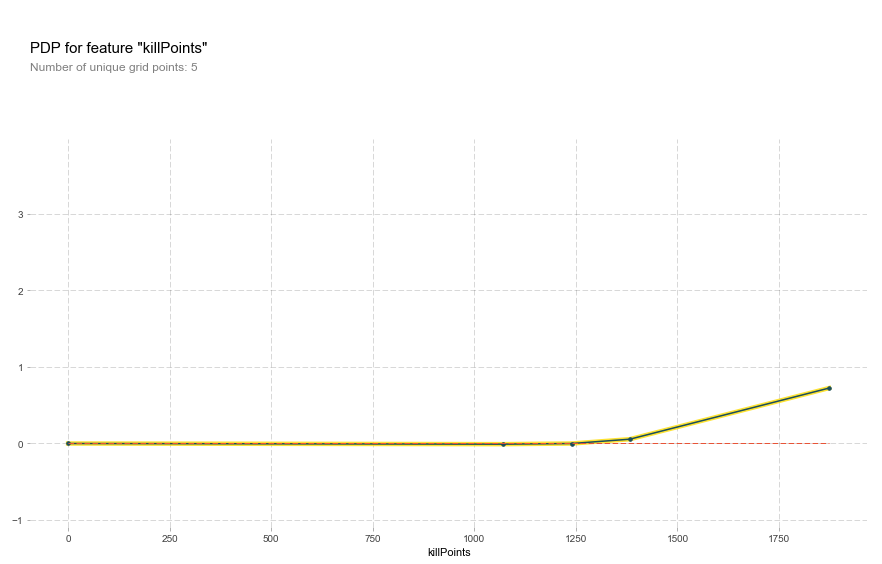

In [35]:
#just replace killPoints with whatever you want to look at
plot_pdp('killPoints', m_fpp, x, clusters=1)

In [33]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, xticks=[0.1,0.2,0.3,0.4,0.5,0.6])

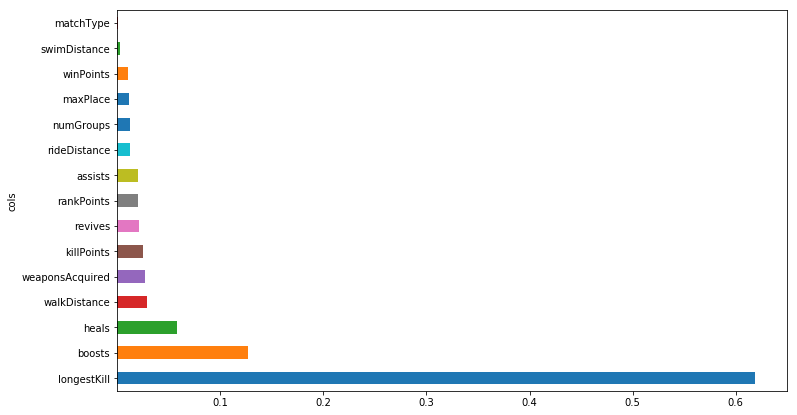

In [34]:
plot_fi(fi_fpp[:15]);